# Playing Atari with Deep Reinforcement Learning (RL 과제)

본 과제는 Deepmind사의 동명의 [논문](https://arxiv.org/abs/1312.5602)(arXiv:1312.5602 [cs.LG])을 리뷰하는 과제다.


# Introduction

### Deep Learning on Reinforcement Learning
Vision이나 High-dimensional Sensory Input과 같은 고차원적 데이터를 강화학습에 적용하고자 하는 시도는 오래 전 부터 있어 왔다. 딥러닝 기술은 이러한 데이터를 성공적으로 적용해서 CNN, RNN 등을 만들었고 이를 사용해 지도/비지도 학습을 수행해 왔으며, 성공적이었다.

이러한 이유로 본 논문은 강화학습(Reinforcement Learning)에 신경망 기술을 접목시켰다.

Q-learning 방법으로 강화학습을 수행한다고 할 때, 본 논문에서는 Q값 (차후에 설명한다)을 구하는 방법을 인공신경망으로 대체하여 학습시켰고, 높은 결과를 나타냈다.

### 인공신경망을 강화학습에 적용하기까지
하지만, 인공신경망을 강화학습에 적용하기에는 일반적인 데이터 기반의 신경망과 강화학습에 몇 가지 차이가 있었다.

강화학습의 차이점을 나열하면 다음과 같다.
```
1. 행동에 대한 보상이 즉각적으로 이루어지지 않는다.(Delayed Result)
2. 행동들 간 상관관계가 높게 형성된다.(Highly Correlated State)
3. 신경망의 목적함수가 학습을 진행할 때마다 값이 변화한다.(non-stationary distributions)
```

본 논문은 이 문제들을 각각 다응과 같은 방법으로 해결했다.
```
1. Experience replay mechanism (이전 시도중에 무작위로 추출한다)
2. 모델을 주기적으로 복사하여 손실함수를 고정시킨다.
```

본문은 이 방법으로 문제를 해결하여 Atari 게임을 하는 인공지능을 만들었다.

### Atari game 에 적용
이 인공지능은 사람과 같이 시각적 정보(게임 화면에 대한 픽셀 정보)만을 input으로 하고 가능한 Action들만을 선택하는 방법으로 게임을 수행한다. 이 방법은 7가지 게임 중 6가지 게임에서 기존 방법보다 더 나은 성과를 보였다.

동일한 네트워크 구조를 다양한 게임에 적용시켰다.

# Background

### 기본적인 강화학습의 방법

E를 아타리 게임의 시뮬레이터, at는 t시점에서 할 수 있는 행동이라고 하자. 현재 활동에서 그 행동을 취하면, 네트워크는 at에 대한 보상 rt를 받게 된다.

이 논문에서 구현한 바에 따르면, at는 게임 시뮬레이터의 화면 픽셀 정보이며, rt는 게임 점수의 변화를 나타낸다.

매 시점마다 다음 반복을 수행한다.
```
- Agent에게 상황 정보(게임 화면의 픽셀)이 주어진다. 
- Agent가 action(at)을 선택한다.
- Agent가 선택한 행동에 대해 게임 스코어가 변화한다.
- Agent는 적절한 보상(rt)를 받는다.
- rt를 네트워크에 적용한다.
- 다시 최대 rt값을 받을 수 있는 방향으로 행동을 선택한다.
```

### 시간 정보 추가
이 방법은 네트워크가 현재의 시간에 대해서만 판단을 하게 된다. 따라서 시간을 조금 더 길게 잡는다.

특정 시점 t에서만 보상과 행동을 파악했다면, 이제는 특정 시점 t부터 게임이 끝날 때까지의 행동 보상을 포함한다. 

즉 이 행동 시점의 보상을 다음과 같이 정의하게 되는 것이다.

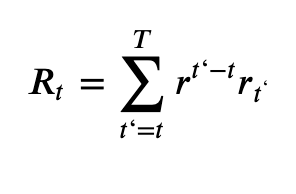

- 보상 앞에 정의된 r^(t' -t)는 discount factor 로 정의되며, 시간이 오래 지날수록 보상의 크기가 작아지는 것을 나타낸다.
- T는 게임이 종료되는 시점이다.

저 식을 다시 한번 해석하자면, '현재 시점부터 게임이 끝날 시점까지 보상(rt)의 가중합을 현재 시점의 보상으로 선택하겠다.' 라는 뜻이다.

이렇게 정의된 보상들은 현재 시점에서 action에 따라 여러 개가 존재할 것이다.

즉 현재 상항에서 Reward가 최대가 되는 경우의 행동을 선택하기 위해서 행동을 선택하는 함수(action-value-function)을 다음과 갈이 정의한다.

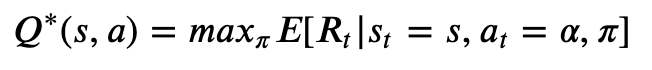

- 수식에서 E는 현재 시점의 환경이다.
- s, st는 sequence이며 현재 행동 과정을 정의한다.
- Q* 는 현대 시점의 이상적인 최대값을 말한다.
- 𝜋는 현재 선택하는 정책 할당 sequence를 말한다. (행동을 거쳐서 오는 보상 - R)
- 위 방정식은 Bellman Equation이라는 특성을 따른다. (후술한다.)

즉 **현재 시점에서 가능한 행동의 보상을 전부 살펴본 뒤 보상이 가장 큰 행동을 실시한다**를 말하는 것이다.

### 반복의 실시

앞서 구한 Q* 를 보면, 앞으로의 상황에 대한 모든 경우의 수를 판단해야한다는 것을 확인할 수 있다. 하지만 게임이나 Sequence 가 커지면 커질 수록 모든 경우의 수를 파악하기는 불가능하다는 사실을 알 수 있다.

이때 등장하는 개념이 벨만 방정식이다.

벨만 방정식은 다음과 같다. 
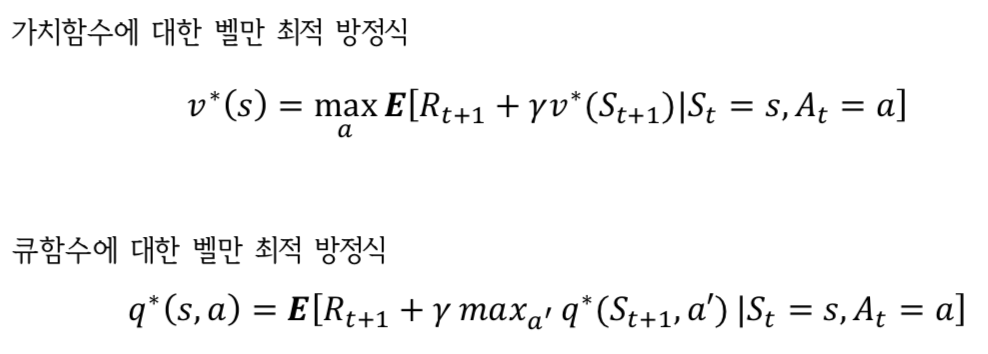

큐함수에 대한 벨만 방정식에 따라 최적 전략은 현재 보상과 미래 최대 보상의 합으로 나타낼 수 있다.

즉 최적의 전략은 다음 수식으로 나타내어진다.
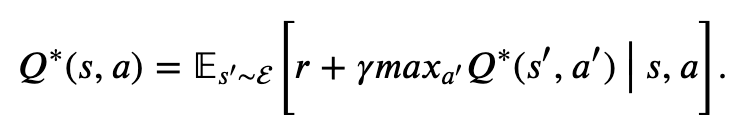
- r은 현 시점의 보상을 의미한다.
- Q*(s',a')는 한 타임 미래 시점의 보상을 의미한다.

즉 **현재 시점의 보상은 다음 타임에서 얻을 수 있는 보상의 최대값에 감가율을 곱한 뒤, 다음 타임의 보상 을 더하는 방법으로 구한다.**

### 손실 함수 구하기
위에서 정의한 Q*를 최적의 경우라고 하면 목표 함수의 target으로 정의할 수 있을 것이다.

앞서 말했듯 모든 경우의 수를 한 번에 아는 것이 불가능하기 때문에 사용자는 위 알고리즘에서 사용되는 Q*값과 근사한 함수를 구한다고 생각하고 이를 Qi로 둔다.

Qi는 iteration을 통해 Q*과의 차이를 줄이는 방법으로 학습을 진행한다.

즉 손실함수를 다음과 같이 설정하고 학습을 진행할 것이다.

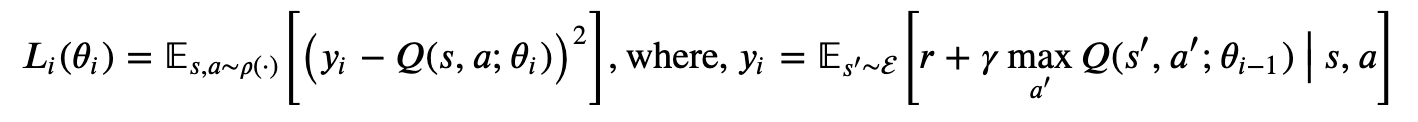

- 손실함수 Li는 주어진 환경 E에서 Q*과 Qi의 차이의 제곱으로 주어진다.
- Q*는 현 시점에서의 벨만 최적 방정식(직후 시점의 보상 + 직후 시점에서 받을 모든 보상 중 최대값)
- Qi는 사용자가 설정해 Gradient Descent 방식을 사용해 학습시키는 함수다.

### Gradient

이와 같은 손실함수의 그래디언트를 구하면 다음과 같이 정의된다.
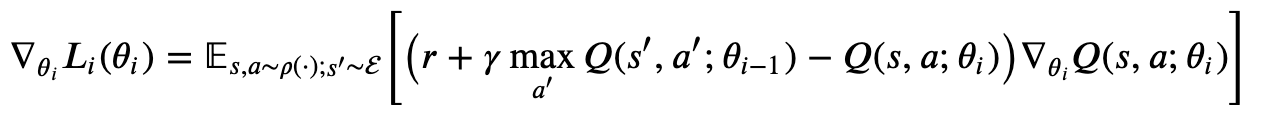

### 알고리즘의 특징
이 알고리즘은 다음과 같은 특징을 갖는다.
- E와 별개로 작동하는 model-free 알고리즘이다.
- Behavior와 Learning Policy를 별도로 두는 off-Policy를 사용한다.(행동의 판단의 기준으로 삼는 정책과, 학습하는 정책이 다르다는 뜻이다.)
- RL의 데이터들은 서로 상관관계가 매우 강하기 때문에 상황을 선택하는 것은 Random Action을 선택한다.
- E-Greedy(입실론 그리디 알고리즘)을 따른다. 이것은 일정 비율(입실론 - 하이퍼파라미터)로는 랜덤으로 action을 선택하고 남은 비율로는 (1 - 입실론) 최적의 결과를 냈던 Action을 선택한다. 

# Related Work

### TD-gammon
Reinforce Learning이 성공한 사례로 가장 유명한 것은 TD-gammon 이다.

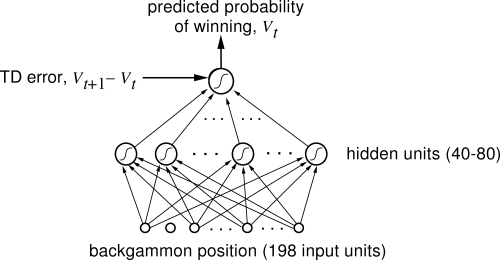

(출처 : http://incompleteideas.net/book/first/ebook/node108.html)

TD-gammon은 Model free한 구조로, 1개의 은닉층을 가진 MLP구조이다.
하지만 이는 바둑이나 체스에 적용할 때는 실패했다.

### 기타 시도

Q-learning을 비선형 목적함수나, off-policy 학습에 적용해 보았으나, 네트워크가 발산하는 결과를 확인했다.

최근에는 Q-learning과 딥러닝 방법을 결합하려는 시도가 많았고, 주로 환경 E를 확인하기 위해 사용되었다.

제한된 볼츠만 기계는 value function이나 policy를 측정하기 위해 사용되기 시작했다고 한다.

하지만 이는 nonlinear control 까지 확장되지는 못했다.

### NFQ

Neural Fitted Q-learning 방법이 논문의 접근법과 가장 유사한데, 이는 RPROP 알고리즘을 활용해 손실 함수를 최적화시켰다.

Stochasitc Gradient Descent 방법을 사용했으며, 큰 데이터셋에까지 학습을 사용했다.

Task에 오토인코더 기술을 적용하여 차원을 낮추고, 이를 성공적으로 적용했다.

### Atari 2600

아타리2600 예뮬레이터는 강화학습 플랫폼으로 사용된다. HyperNEAT evolutionaly architecture가 적용되었다.



# Deep Reinforcement Learning

본 논문은 새로운 학습 기법인 Deep Q Learning (DQN)을 도입했다.

### 알고리즘의 특징
DQN은 다음과 같은 특징을 가진다.
- TD-gammon과는 다르게, 특정 상황 et = (st, at, rt, s(t+1))을 replay Memory(D)라는 공간에 저장만 하고, 학습하지는 않는다.
- 저장이 끝나면, D에서 몇 개의 et들을 Uniform Select 해 Q-learning 을 진행한다.
- 이 방법은 마치 미니배치 학습과 비슷한 양상을 띈다.
- Q-learning을 진행할 때에는 e-greedy 방법을 써서 학습한다.
- et는 sequence의 길이의 차이가 있을 수 있으므로,  𝜙 함수를 사용하여 가변 길이를 입력받을 것이다.


### 알고리즘 설명

![image](https://i.stack.imgur.com/Jnyff.jpg)

1. Replay Memory(D)를 N의 크기로 초기화한다.
2. action-value function(Q)를 랜덤 가중치로 초기화한다.
3. M번 반복한다.
4. Squence 를 초기화한다.
5. 초기 시점부터 게임이 끝날 시점까지의 반복하며, 시점을 t로 둔다. (게임을 실시한다)
6. E-greedy 알고리즘에 의해 입실론 확률로 랜덤한 at를 선택하거나
7. t시점에서 보상을 가장 크게 받는 행동으로 at를 선택한다.
8. 에뮬레이터에서 행동 at를 실행하며, 보상 rt와 다음 시점의 화면 모습 x(t+1)을 확인한다.
9. s(t+1)을 st, at, x(t+1)로 두며, s(t+1)의 길이를 통일하기 위해 파이 함수에 적용한다.
10. 이렇게 만들어진 정보들을 Replay Memory(D)에 저장한다.
11. Replay Memory에서 랜덤한 시점의 값을 추출한다. - 시간이 지날수록 추출되는 값의 수는 많아질 것이다.
12. 추출된 시점이 마지막 시점인 경우는 행동 보상만 target으로 하고, 그렇지 않으면 앞 공식에 의해 미래 시점의 최대 보상도 추가해서 target 으로 한다.
13. Gradient descent 로 학습 함수의 학습을 실시한다. 이때 손실 함수는 학습하는 함수와 12행에서 설정한 목표함수의 차이의 제곱이다.
14. 5번 행의 반복을 끝낸다.
15. 3번 행의 반복을 끌낸다.

Nature 지에 있는 Paper에는 학습용 함수와 target 함수를 다르게 설정해주는 의사코드도 적혀 있다.
![이미지](https://curt-park.github.io/images/dqn/algorithm.png)

- 여기서 3행은 Q'의 가중치값을 2 행에서 정의한 Q함수 값으로 복사한다.
- 반복을 끝내기 전에 Q'함수의 가중치를 Q 함수로 복사한다.
- 손실 함수 L은 (Q - Q')^2 가 된다.

### 장점

DQN 은 Q-learning에 비해 다음 장점을 갖는다.

```
1. each step의 Experience 가 더 많은 weight update에 재사용되므로 data-efficiency 하다.
2. random하게 추출하고, e-greedy 알고리즘으로 추출하여, 데이터간의 high correlations 문제를 해결했다.
3. 매개변수가 학습될수록 점점 sample들이 올바르게(보상을 최대화하는 방향) 편향될 것이다. 즉 보상을 최대화하는 방향의 샘플들이 추출되는 빈도가 증가할 것이고, 이는 원치 않는 loop의 발생 빈도를 줄인다.
```

3번과 같은 장점은 다음 상황을 막는다고 볼 수 있다.
- 현재 A위치에서 최고의 보상을 주는 행동은 B위치로 이동하는 것이다.
- 현재 B위치에서 최고의 보상을 주는 행동은 A위치로 이동하는 것이다.
- 이 상황은 A나 B가 아닌 다른 위치에서 Q-learning 학습이 진행되거나, 랜덤한 상황을 통해 벗어날 수 있다.
- 그렇지 않으면 계속 A와 B를 반복하는 unwanted feedback loops를 막는다.

## Preprocessing and Model Architecture

아타리 게임의 배경은 210 x 160 픽셀에 128 color palette를 가지고 있는 이미지이다. 따라서 다음과 같은 전처리를 거쳤다.

- 학습을 용이하게 하기 위해서 RGB 색상을 gray-scale로 변환했다.
- 이미지를 110 x 84 로 다운샘플링 시켰다.
- 전체 화면에서 84 x 84 크기의 정사각형 형태의 이미지로 crop했다. (GPU와 2D Conv 레이어를 사용해 학습시키기 위해서)

![DQN](https://t1.daumcdn.net/cfile/tistory/99137D455B98F61C04)

(이미지 출처 : https://sumniya.tistory.com/18)

### DNN Architecture

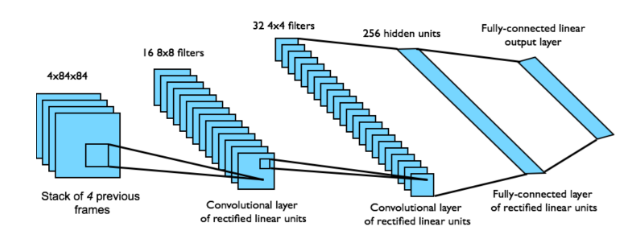
- 신경망의 Input은 𝜙 를 통해 같은 시계열로 맞춘 84 x 84 x 4 이미지(4 frames)이다.
- 첫 번째 Hidden Layer는 stride 4인 16*8x8 필터로 합성곱 연산을 수행한다
- activation으로 relu를 수행한다.
- 두번째 Hidden Layer는 stride 2를 포함한 32*4x4 필터로 합성곱 연산을 수행한다.
- activation으로 relu를 수행한다.
- 세번째 Hidden Layer는 funnly-connected되고, 256개의 노드로 구성된다.
- Output layer는 각 수행가능한 행동에 대해 single output을 갖는 fully-connected linear layer다.


# Experiments

위 신경망을 활용해 만든 인공지능으로 7개의 아타리 게임을 학습습시켰다.

7개 게임 모두 같은 구조의 네트워크와 학습 알고리즘, 하이퍼파라미터를 사용했다. 이는 즉 이 알고리즘이 Robust한 것을 확인할 수 있었다.

게임마다 점수 체계가 다르기 때문에 Positive 한 보상은 1로, Negative한 보상은 -1로, 변화가 없는 경우는 0으로 통일했다.

이렇게 하면 모든 게임에 대해 같은 learning rate를 적용할 수 있다는 장점이 생긴다.

최적화 알고리즘으로 RMSProp를 사용했으며, Batch_size는 32 였다.

e-greedy 알고리즘의 입실론 값은 첫 백만프레임에서는 1에서 0.1로 감소시켰고 그 후에 0.1로 고졍시켜 점차 랜덤성을 줄였다.

전체 천만 프레임을 학습시켰으며, 백만 개의 프레임을 저장할 수 있게 replay memory를 설계했다.

이에 더해 연구팀은 frame-skipping technique를 적용했는데, k프레임을 기준으로 행동을 수정하는 방법이다.
'Space Invaders' 를 제외하면 모두 k=4였으며, 'Space Invaders'는 레이저가 깜빡이는 프레임 간격 때문에 k=3으로 설정했다.


## Training and Stability

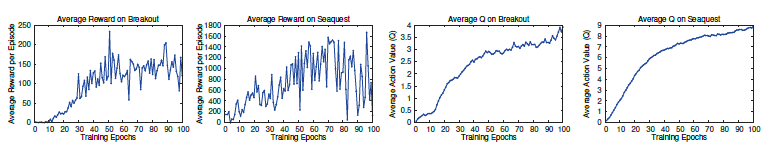

RL 은 Supervised Learning과 다르게 학습 중에 progress를 정확히 측정하는 것이 매우 어렵다.

하나의 episode나 한 게임에서 수집한 데이터를 평균해서 구하는 것이 Total Reward이므로, training과정에서 주기적인 컴퓨팅을 실시했다.

average total reward metric은 작은 가중치 변화도 큰 결과의 차이를 보일 수 있어서 Noisy하다고 한다. (왼쪽 두 개 그래프)

더 안정적인 측정 방법은 정책의 action-value function인 Q 값 (특정 상태에서 앞으로 얻을 보상 값의 총합)을 측정하는 것이었다.(오른쪽 두 개 그래프)

학습 과정에서 Q값이 발산하는 것을 경험하지 못했다. 이론적인 증거는 없을 수 있어도 논문에서 나온 방법이 안정적인 방법이라는 것을 시사할 수 있다.


## Visualizing the Value Function

위 그림은 게임이 진행됨에 따라 value function의 값을 그래프로 표시했다.

- A지점에서 적이 등장하자 값이 뛰는 모습을 보였으며 레이저를 발사했다. (죽였을 때 보상이 커질 것을 예상했기 때문)
- B지점에서 레이저가 적을 맞추기 직전에 다시 한번 뛰는 모습을 보인다. (적이 죽을 것을 예상했기 때문)
- C지점에서 적이 사라지고 Value Function이 다시 원상태로 복귀하는 모습을 확인할 수 있었다.

## Main Evaluation
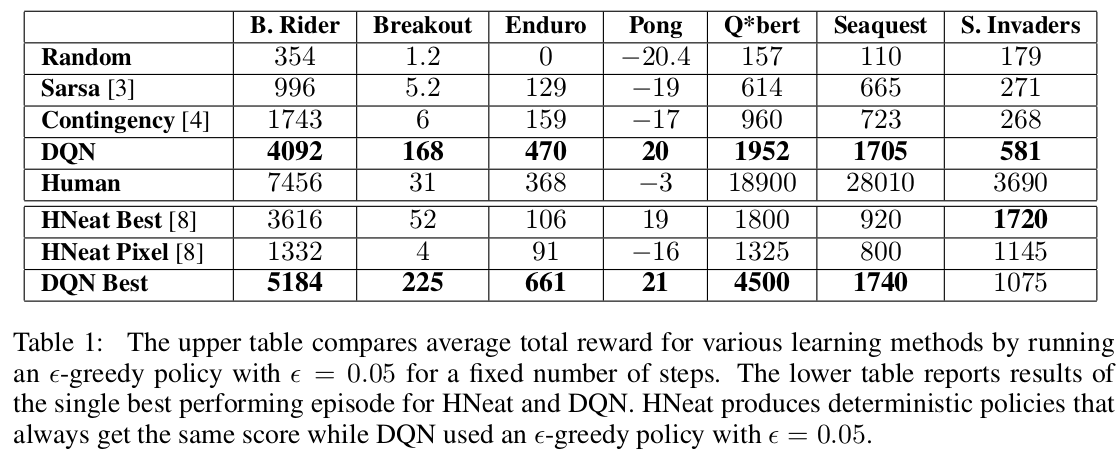

다른 알고리즘과 DQN 알고리즘을 비교해 보았다.

비교를 해 본 알고리즘은 다음과 같다.
- Random : 완전 무작위 선택
- Sarsa : Sarsa 알고리즘 (Atari Task를 처리하기 위해 수작업으로 설계된 특징들)
- Contingency : Sarsa 알고리즘 (Sarsa 와 접근법은 같은데 feature set을 augment 시켰다.)
- DQN
- HNeat Best : 사람이 손으로 작업한(Hand-engineer된 알고리즘)
- HNEAT Pixel : 사람이 손으로 작업한(Hand-engineer된 알고리즘)
- Human : 사람이 직접 프로그래밍

테스트 결과 사람을 제외한 가장 높은 점수를 기록했다.


# Conclusion

- 이 논문은 Reinforcement Learning 에 Deep learning Model 을 적용했고, 아타리 2600의 복잡한 Control Policy를 다룰 수 있다는 것을 보여주었다.
- 모델의 Input은 raw pixel이었다.
- 논문에서 제안한 방법은 Stochastic minibatch 방법과 replay memory를 적용했다.
- 테스트 결과 모든 결과에서 인간을 제외한 가장 높은 정수를 얻게 되었으며, 게임마다 파라미터 조정을 하지 않고 나온 수치이다.


# 참고자료

- Playing Atari with Deep Reinforcement Learning - https://arxiv.org/abs/1312.5602
- Google DeepMind's Deep Q-learning playing Atari Breakout - https://www.youtube.com/watch?v=V1eYniJ0Rnk&t=10s
- Q 러닝 - Grid World 예제 - https://www.youtube.com/watch?v=nGQDoqPlWrY
- [논문번역] Playing Atari with Deep Reinforcement Learning 논문 설명/요약 - https://mangkyu.tistory.com/60
- Playing Atari with Deep Reinforcement Learning - https://velog.io/@kth811/1.-Playing-Atari-with-Deep-Reinforcement-Learning
- Lecture 7: DQN - https://www.youtube.com/watch?v=S1Y9eys2bdg&t=956s